# Packages

In [1]:
%%capture
!pip install rdkit

In [2]:
# Basic data manipulation
import numpy as np
import pandas as pd

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import Descriptors

# XG boost
import xgboost as xgb

# Sklearn for downstream prediction
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Pytorch for finetuning BERT model
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

# Load transformer model
from transformers import AutoModelForMaskedLM, AutoTokenizer, AutoModel, AutoModelForSequenceClassification

# Dataset and Pretrained Model

* The training dataset `train.csv` is loaded to `df_train`.
* The transformer model `ChemBerta` is available in Kaggle (https://www.kaggle.com/code/michaelrowen/opp2025-chemberta-pre-trained-base).

In [3]:
df_train = pd.read_csv('/kaggle/input/melting-point/train.csv')
df_test = pd.read_csv('/kaggle/input/melting-point/test.csv')
chemberta_model = '/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM'

+ The dataset is split into 80/20 for training and validation.

In [4]:
seed = 20251017
torch.manual_seed(seed)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=seed)

+ Standardization $(y_i-\bar{y})/s$ is applied to the target, melting points `Tm`.
+ The standardized target values are denoted by `TmS`.

In [5]:
scaler = StandardScaler()
scaler.fit(df_train[['Tm']]) # pass in 2D array
std = scaler.var_[0]**0.5 # estimate of s

df_train['TmS'] = scaler.transform(df_train[['Tm']]).flatten() # convert back to 1D array 
df_val['TmS'] = scaler.transform(df_val[['Tm']]).flatten()

+ Define the data handler for fine-tuning ChemBerta with pytorch.

In [6]:
class ChemDataset(Dataset):  
    def __init__(self, df, tokenizer, max_length=128):  
        self.smiles = df['SMILES'].tolist()  
        self.labels = df['TmS'].tolist()  
        self.tokenizer = tokenizer  
        self.max_length = max_length  
  
    def __len__(self):  
        return len(self.labels)  
  
    def __getitem__(self, idx):  
        encoding = self.tokenizer(  
            self.smiles[idx],  
            truncation=True,  
            padding='max_length',  
            max_length=self.max_length,  
            return_tensors='pt'  
        )  
        item = {key: val.squeeze(0) for key, val in encoding.items()}  
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)  
        return item  

+ Define the transformer model ChemBerta.
+ A regression head is added on top of the transformer model.

In [7]:
# Model retrieved from https://www.kaggle.com/code/michaelrowen/opp2025-chemberta-pre-trained-base
class BERTEmbedder:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(  
            model_name,
            num_labels=1,  
            problem_type='regression' # Regression task  
        )  
        self.model.eval()

# Finetuning ChemBERTA

+ Load the transfomer model and define data handlers for training and validation sets, respectively.

In [8]:
# Training configuration
chemberta = BERTEmbedder(model_name=chemberta_model)
optimizer = AdamW(chemberta.model.parameters(), lr=1e-4) # lr set by experiment
loss_fn = nn.L1Loss() # Since reduce = mean, L1Loss measures MAE
n_epochs = 30

# Data handler
dataset_train = ChemDataset(df_train, chemberta.tokenizer)
dataset_val = ChemDataset(df_val, chemberta.tokenizer)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True) # batch_size set by experiment
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=True) # batch_size set by experiment

2025-11-02 03:33:35.945683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762054416.401731      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762054416.531687      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


+ Move the model to GPU on Kaggle platform and start training.

In [9]:
# Enable GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
chemberta.model.to(device)

train_loss_list = []
val_loss_list = []
# Training cycle
for epoch in range(n_epochs):
    chemberta.model.train()
    epoch_train_size = 0
    epoch_val_size = 0
    epoch_train_loss = 0
    epoch_val_loss = 0

    # evaluate training set
    for batch in dataloader_train:
        # forward pass
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}  
        labels = batch['labels'].to(device).unsqueeze(1)  # shape [B,1]  
        outputs = chemberta.model(**inputs).logits  # shape [B,1] 
        loss = loss_fn(outputs, labels)  

        # backward pass
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        # update epoch loss
        epoch_train_loss += loss.item() * dataloader_train.batch_size * std
        epoch_train_size += dataloader_train.batch_size
    
    # evaluate validation set
    with torch.no_grad():
        for batch in dataloader_val:
            # forward pass
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}  
            labels = batch['labels'].to(device).unsqueeze(1)  # shape [B,1]  
            outputs = chemberta.model(**inputs).logits  # shape [B,1] 
            loss = loss_fn(outputs, labels)  

            # update epoch loss
            epoch_val_loss += loss.item() * dataloader_val.batch_size * std
            epoch_val_size += dataloader_val.batch_size

    # compute loss per epoch
    avg_train_loss = epoch_train_loss/epoch_train_size
    avg_val_loss = epoch_val_loss/epoch_val_size

    # save model with the lowest validation loss
    if len(val_loss_list) > 0 and avg_val_loss < np.min(val_loss_list):
        torch.save(chemberta.model.state_dict(), '/kaggle/working/weights.pth')
        
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    print(f"Epoch {epoch + 1} done, training loss: {avg_train_loss:.4f}, validation loss: {avg_val_loss:.4f}")  

Epoch 1 done, training loss: 49.3997, validation loss: 43.1056
Epoch 2 done, training loss: 39.6177, validation loss: 39.6687
Epoch 3 done, training loss: 35.7749, validation loss: 38.3034
Epoch 4 done, training loss: 34.0615, validation loss: 38.3894
Epoch 5 done, training loss: 33.1421, validation loss: 35.8712
Epoch 6 done, training loss: 31.0938, validation loss: 36.1660
Epoch 7 done, training loss: 30.6721, validation loss: 35.9603
Epoch 8 done, training loss: 30.1994, validation loss: 35.7469
Epoch 9 done, training loss: 29.6961, validation loss: 34.8828
Epoch 10 done, training loss: 29.1728, validation loss: 35.1235
Epoch 11 done, training loss: 28.9291, validation loss: 35.2323
Epoch 12 done, training loss: 28.1107, validation loss: 35.7300
Epoch 13 done, training loss: 26.7907, validation loss: 36.7645
Epoch 14 done, training loss: 26.6994, validation loss: 34.6290
Epoch 15 done, training loss: 26.6998, validation loss: 35.4138
Epoch 16 done, training loss: 25.3843, validation

In [10]:
# Load the best model
chemberta.model.eval()
chemberta.model.to('cpu')
chemberta.model.load_state_dict(torch.load('/kaggle/working/weights.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

+ The validation loss seems to be converged after 15 epochs. 

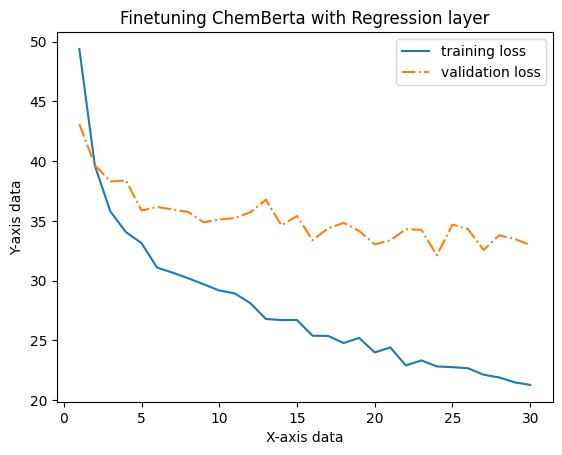

In [11]:
import matplotlib.pyplot as plt
plt.plot([i + 1 for i in range(n_epochs)], train_loss_list, label ='training loss')
plt.plot([i + 1 for i in range(n_epochs)], val_loss_list, '-.', label ='validation loss')

plt.xlabel("X-axis data")
plt.ylabel("Y-axis data")
plt.legend()
plt.title('Finetuning ChemBerta with Regression layer')
plt.show()

# Generate Features

In [12]:
def extract_chembert_embeddings(smiles_list, embedder, n_data):
    n_latent = 384
    embeddings = np.zeros((n_data, n_latent))
    
    for i, smiles in enumerate(smiles_list):
        with torch.no_grad():
            # Getting the model output
            encoded_input = embedder.tokenizer(smiles, return_tensors='pt', padding=True, truncation=True)
            model_output = embedder.model(**encoded_input, output_hidden_states=True)
            # embeddings[i, :] = model_output.logits.numpy()
            
            # Getting the CLS token from model output
            embedding = model_output.hidden_states[3][:, 0, :]
            embeddings[i, :] = embedding.numpy()
    
    return pd.DataFrame(embeddings, columns=[f'embedding_{i+1}' for i in range(n_latent)])

In [13]:
# Code retrieved from https://www.kaggle.com/code/aliffaagnur/single-lightgbm-optuna/notebook
def extract_all_descriptors(smiles_list):

    # GET ALL DESCRIPTORS
    descriptor_list = Descriptors._descList    # --> THESE WILL RETURN LIST OF TUPLE
    descriptors = [desc[0] for desc in descriptor_list]

    print(f'There Are {len(descriptor_list)} Descriptor Features')

    # EXTRACT ALL DESCRIPTORS FROM SMILES FEATURES
    result = []
    for smiles in smiles_list:

        mol = Chem.MolFromSmiles(smiles)

        # IF MOLECOLE IS INVALID
        if mol is None:
            row = {name : None for name, func in descriptor_list}
        else:
            # CREATE DESCRIPTORS FEATURES
            row = {name: func(mol) for name, func in descriptor_list}

        result.append(row)

    # MERGE DATA WITH EXTRACTED FEATURES
    return pd.DataFrame(result)

In [14]:
# Generate features for training set
embeddings_train = extract_chembert_embeddings(df_train['SMILES'], chemberta, df_train.shape[0])
molecular_features_train = extract_all_descriptors(df_train['SMILES'])

# Generate features for validation set
embeddings_val = extract_chembert_embeddings(df_val['SMILES'], chemberta, df_val.shape[0])
molecular_features_val = extract_all_descriptors(df_val['SMILES'])

There Are 217 Descriptor Features
There Are 217 Descriptor Features


In [15]:
# Dataset size
print('Training set')
print(embeddings_train.shape, type(embeddings_train))
print(molecular_features_train.shape, type(molecular_features_train))

print('Valiodation set')
print(embeddings_val.shape, type(embeddings_val))
print(molecular_features_val.shape, type(molecular_features_val))

Training set
(2129, 384) <class 'pandas.core.frame.DataFrame'>
(2129, 217) <class 'pandas.core.frame.DataFrame'>
Valiodation set
(533, 384) <class 'pandas.core.frame.DataFrame'>
(533, 217) <class 'pandas.core.frame.DataFrame'>


# Downstream Prediction Task

In [16]:
# Dataset for sklearn - Training set
df_ttl_train = pd.concat([
    df_train.reset_index(drop=True), 
    embeddings_train, 
    molecular_features_train
], axis=1)
y_train = df_ttl_train['TmS']
X_train = df_ttl_train.drop(df_train.columns, axis=1)
#X_train = df_ttl_train.drop(['id', 'Tm', 'TmS', 'SMILES'], axis=1)
X_train.columns = [str(colname) for colname in X_train.columns]

# Dataset for sklearn - Validation set
df_ttl_val = pd.concat([
    df_val.reset_index(drop=True), 
    embeddings_val, 
    molecular_features_val
], axis=1)
y_val = df_ttl_val['TmS']
X_val = df_ttl_val.drop(df_val.columns, axis=1)
#X_val = df_ttl_val.drop(['id', 'Tm', 'TmS', 'SMILES'], axis=1)
X_val.columns = [str(colname) for colname in X_val.columns]

## Extreme Gradient Boosting

In [17]:
# Define hyperparameter grid for optimization  
param_grid = {
    'n_estimators' : [200, 500, 700, 1000],
    'max_depth': [3, 7],
    'eta': [0.05, 0.1, 0.15],
    'subsample': [0.7],
    'colsample_bytree': [0.8]
}
mae_scores = []

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for eta in param_grid['eta']:
            for subsample in param_grid['subsample']:
                for colsample_bytree in param_grid['colsample_bytree']:
                    model_xgb = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=eta, subsample=subsample, colsample_bytree=colsample_bytree, random_state=seed)
                    model_xgb.fit(X_train, y_train)
                    y_pred = model_xgb.predict(X_val)
                    mae_score = mean_absolute_error(y_val, y_pred) * std
                    mae_scores.append([n_estimators, max_depth, eta, subsample, colsample_bytree, mae_score])
                    
df_downstream = pd.DataFrame(mae_scores, columns=['n_estimators', 'max_depth', 'eta', 'subsample', 'colsample_bytree', 'mae_score']) 

In [18]:
df_downstream.sort_values(by='mae_score', inplace=True)
df_downstream.head()

,n_estimators,max_depth,eta,subsample,colsample_bytree,mae_score
21,1000,7,0.05,0.7,0.8,29.708943
15,700,7,0.05,0.7,0.8,29.723066
9,500,7,0.05,0.7,0.8,29.755721
18,1000,3,0.05,0.7,0.8,29.835230
3,200,7,0.05,0.7,0.8,29.899546


In [19]:
# Retrieve the best model parameters
best_model_config = df_downstream.nsmallest(1, 'mae_score').\
    drop('mae_score', axis=1).\
    iloc[0, :].to_dict()

# Type correction
best_model_config['max_depth'] = int(best_model_config['max_depth'])
best_model_config['n_estimators'] = int(best_model_config['n_estimators'])

# Train the downstream model with the best parameters
best_model = xgb.XGBRegressor(random_state=seed, **best_model_config)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

# Submission

In [20]:
# Generate features for the test set
embeddings_test = extract_chembert_embeddings(df_test['SMILES'], chemberta, df_test.shape[0])
molecular_features_test = extract_all_descriptors(df_test['SMILES'])

# the best downstream regression model
# model = ElasticNet(random_state=seed, alpha=0.03, l1_ratio=0.1)
# model.fit(X_train, y_train)

# Prepare dataset for downstream regression tasks
df_ttl_test = pd.concat([
    df_test.reset_index(drop=True), 
    embeddings_test, 
    molecular_features_test
], axis=1)


X_test = df_ttl_test.drop(df_test.columns, axis=1)
X_test.columns = [str(colname) for colname in X_test.columns]

y_pred = scaler.inverse_transform( # back transform to raw target
    np.expand_dims(best_model.predict(X_test), axis=1) # convert to 2D array by adding an extra dimension
)

There Are 217 Descriptor Features


In [21]:
df_out = pd.DataFrame({'id': df_ttl_test['id'],'Tm': y_pred.flatten()})
df_out.to_csv('./submission.csv', index=False)